# Wstęp

Metody uczenia maszynowego możemy podzielić na dwie główne kategorie (pomijając uczenie ze wzmocnieniem): nadzorowane i nienadzorowane. Uczenie **nadzorowane** (ang. *supervised*) to jest uczenie z dostępnymi etykietami dla danych wejściowych. Na parach danych uczących $dataset= \{(x_0,y_0), (x_1,y_1), \ldots, (x_n,y_n)\}$ model ma za zadanie nauczyć się funkcji $f: X \rightarrow Y$. Z kolei modele uczone w sposób **nienadzorowany** (ang. *unsupervised*) wykorzystują podczas trenowania dane nieetykietowane tzn. nie znamy $y$ z pary $(x, y)$.

Dość częstą sytuacją, z jaką mamy do czynienia, jest posiadanie małego podziobioru danych etykietowanych i dużego nieetykietowanych. Często annotacja danych wymaga ingerencji człowieka - ktoś musi określić co jest na obrazku, ktoś musi powiedzieć czy dane słowo jest rzeczownkiem czy czasownikiem itd.

Jeżeli mamy dane etykietowane do zadania uczenia nadzorowanego (np. klasyfikacja obrazka), ale także dużą ilość danych nieetykietowanych, to możemy wtedy zastosować techniki **uczenia częściowo nadzorowanego** (ang. *semi-supervised learning*). Te techniki najczęściej uczą się funkcji $f: X \rightarrow Y$, ale jednocześnie są w stanie wykorzystać informacje z danych nieetykietowanych do poprawienia działania modelu.

## Cel ćwiczenia

Celem ćwiczenia jest nauczenie modelu z wykorzystaniem danych etykietowanych i nieetykietowanych ze zbioru STL10 z użyciem metody [Bootstrap your own latent](https://arxiv.org/abs/2006.07733).

Metoda ta jest relatywnie "lekka" obliczeniowo, a także dość prosta do zrozumienia i zaimplementowania, dlatego też na niej się skupimy na tych laboratoriach.

# Zbiór STL10

Zbiór STL10 to zbiór stworzony i udostępniony przez Stanford [[strona]](https://ai.stanford.edu/~acoates/stl10/) [[papier]](https://cs.stanford.edu/~acoates/papers/coatesleeng_aistats_2011.pdf) a inspirowany przez CIFAR-10. Obrazy zostały pozyskane z [ImageNet](https://image-net.org/). Szczegóły można doczytać na ich stronie. To co jest ważne to to, że autorzy zbioru dostarczają predefiniowany plan eksperymentalny, żeby móc porównywać łatwo wyniki eksperymentów. Nie będziemy go tutaj stosować z uwagi na jego czasochłonność (10 foldów), ale warto pamiętać o tym, że często są z góry ustalone sposoby walidacji zaprojetowanych przez nas algorytmów na określonych zbiorach referencyjnych.

Korzystając z `torchvision.datasets` ***załaduj*** 3 podziały zbioru danych STL10: `train`, `test`, `unlabeled` oraz utwórz z nich instancje klasy `DataLoader`. Korzystając z Google Colab rozważ użycie Google Drive do przechowyania zbioru w calu zaoszczędzenia czasu na wielokrotne pobieranie.

In [17]:
# Experiment configuration
RUN_SUPERVISED = True
RUN_UNSUPERVISED = True

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from copy import deepcopy

In [19]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [20]:
from matplotlib import pyplot as plt

def plot_results(results, ncols=2):
    num_rows = len(results)
    fig, axes = plt.subplots(nrows=num_rows, ncols=ncols, figsize=(14, 5 * len(results)))
    if num_rows == 1:
        axes = [axes]
    if ncols == 1:
        axes = [[ax] for ax in axes]

    for ax, (key, values) in zip(axes, results.items()):

        epochs = range(1, len(values['train_loss']) + 1)

        ax[0].plot(epochs, [x for x in values['train_loss']], label='Train Loss')
        # if test loss exists, plot it
        if 'test_loss' in values:
            ax[0].plot(epochs, [x for x in values['test_loss']], label='Test Loss')
        ax[0].set_title(f"{key} Loss")
        ax[0].set_xlabel("Epoch")
        ax[0].set_ylabel("Loss")
        ax[0].legend()

        if ncols == 1:
            continue    
        
        ax[1].plot(epochs, [x for x in values['train_acc']], label='Train Accuracy')
        ax[1].plot(epochs, [x for x in values['test_acc']], label='Test Accuracy')
        ax[1].set_title(f"{key} Accuracy")
        ax[1].set_xlabel("Epoch")
        ax[1].set_ylabel("Accuracy")
        ax[1].legend()

    plt.tight_layout()
    plt.show()

In [21]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.STL10(root='.', split='train', transform=train_transforms, download=True)
test_dataset = datasets.STL10(root='.', split='test', transform=test_transforms, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


# Uczenie nadzorowane

Żeby porównać czy metoda BYOL przynosi nam jakieś korzyści musimy wyznaczyć wartość bazową metryk(i) jakości, których będziemu używać (np. dokładność).

***Zaimplementuj*** wybraną metodę uczenia nadzorowanego na danych `train` z STL10. Możesz wykorzystać predefiniowane architektury w `torchvision.models` oraz kody źródłowe z poprzednich list.

In [22]:
class ModifiedResNet18(nn.Module):
    def __init__(self):
        super(ModifiedResNet18, self).__init__()
        original_model = models.resnet18(weights=None)
        self.features = nn.Sequential(*list(original_model.children())[:-1])  # Remove original FC layer
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(original_model.fc.in_features, 10)  # STL10 has 10 classes

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [23]:
class ModifiedResNet50(nn.Module):
    def __init__(self):
        super(ModifiedResNet50, self).__init__()
        # Load a pretrained ResNet-50
        base_model = models.resnet50(weights=None)
        # Modify the last fully connected layer to match the number of classes in STL10
        num_features = base_model.fc.in_features
        base_model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 10)
        )
        self.base_model = base_model

    def forward(self, x):
        return self.base_model(x)


In [24]:
def initialize_model(model_name, num_classes, use_pretrained=False):
    """Generic function to initialize a model"""
    if model_name == "resnet101":
        model = models.resnet101(pretrained=use_pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == "mobilenet_v2":
        model = models.mobilenet_v2(pretrained=use_pretrained)
        num_ftrs = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_ftrs, num_classes)
        )
    else:
        raise Exception("Invalid model name")
    return model

In [25]:
def train_and_evaluate(model, optimizer, loss_fn, train_dl, val_dl, epochs=10, patience=5):
    """Funkcja trenująca model z mechanizmem early stopping."""
    metrics = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
    }

    best_val_loss = float('inf')
    epochs_no_improve = 0
    early_stop = False

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0
        correct = 0
        total = 0

        for X_batch, y_batch in train_dl:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() * X_batch.size(0)
            correct += (y_pred.argmax(1) == y_batch).sum().item()
            total += y_batch.size(0)

        train_acc = correct / total
        train_loss = epoch_train_loss / total

        model.eval()
        with torch.no_grad():
            epoch_val_loss = 0
            correct = 0
            total = 0

            for X_batch, y_batch in val_dl:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)

                epoch_val_loss += loss.item() * X_batch.size(0)
                correct += (y_pred.argmax(1) == y_batch).sum().item()
                total += y_batch.size(0)

            val_acc = correct / total
            val_loss = epoch_val_loss / total

        metrics['train_loss'].append(train_loss)
        metrics['train_acc'].append(train_acc)
        metrics['test_loss'].append(val_loss)
        metrics['test_acc'].append(val_acc)

        print(f"Epoch {epoch}: train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
              f"test loss = {val_loss:.3f} (acc: {val_acc:.3f})")

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {patience} epochs without improvement")
                early_stop = True
                break

    return metrics

In [26]:
results = {}

In [27]:
if RUN_SUPERVISED:
    model = ModifiedResNet18().to(device)
    results['Resnet18'] = train_and_evaluate(
        model,
        optim.Adam(model.parameters(), lr=0.001),
        nn.CrossEntropyLoss(),
        train_loader, 
        test_loader,
        epochs=100,
        patience=7,
    )

Epoch 0: train loss = 1.820 (acc: 0.311), test loss = 1.685 (acc: 0.380)
Epoch 1: train loss = 1.535 (acc: 0.428), test loss = 1.543 (acc: 0.434)
Epoch 2: train loss = 1.412 (acc: 0.470), test loss = 1.382 (acc: 0.502)
Epoch 3: train loss = 1.241 (acc: 0.544), test loss = 1.290 (acc: 0.543)
Epoch 4: train loss = 1.155 (acc: 0.585), test loss = 1.316 (acc: 0.532)
Epoch 5: train loss = 1.088 (acc: 0.600), test loss = 1.315 (acc: 0.545)
Epoch 6: train loss = 1.087 (acc: 0.607), test loss = 1.352 (acc: 0.541)
Epoch 7: train loss = 0.938 (acc: 0.662), test loss = 1.088 (acc: 0.615)
Epoch 8: train loss = 0.932 (acc: 0.672), test loss = 1.111 (acc: 0.614)
Epoch 9: train loss = 0.840 (acc: 0.702), test loss = 1.286 (acc: 0.556)
Epoch 10: train loss = 0.780 (acc: 0.715), test loss = 1.075 (acc: 0.637)
Epoch 11: train loss = 0.740 (acc: 0.739), test loss = 1.133 (acc: 0.629)
Epoch 12: train loss = 0.700 (acc: 0.748), test loss = 1.106 (acc: 0.648)
Epoch 13: train loss = 0.671 (acc: 0.760), test 

In [28]:
if RUN_SUPERVISED:
    model = ModifiedResNet50().to(device)
    results['Resnet50'] = train_and_evaluate(
        model,
        optim.Adam(model.parameters(), lr=0.001),
        nn.CrossEntropyLoss(),
        train_loader, 
        test_loader,
        epochs=100,
        patience=7,
    )


Epoch 0: train loss = 2.314 (acc: 0.247), test loss = 5.975 (acc: 0.286)
Epoch 1: train loss = 1.763 (acc: 0.355), test loss = 9.829 (acc: 0.290)
Epoch 2: train loss = 1.598 (acc: 0.400), test loss = 1.613 (acc: 0.411)
Epoch 3: train loss = 1.446 (acc: 0.462), test loss = 1.477 (acc: 0.458)
Epoch 4: train loss = 1.384 (acc: 0.488), test loss = 1.529 (acc: 0.464)
Epoch 5: train loss = 1.267 (acc: 0.538), test loss = 1.414 (acc: 0.511)
Epoch 6: train loss = 1.162 (acc: 0.572), test loss = 1.339 (acc: 0.517)
Epoch 7: train loss = 1.083 (acc: 0.619), test loss = 1.212 (acc: 0.551)
Epoch 8: train loss = 1.043 (acc: 0.616), test loss = 1.341 (acc: 0.535)
Epoch 9: train loss = 0.979 (acc: 0.640), test loss = 1.285 (acc: 0.563)
Epoch 10: train loss = 0.942 (acc: 0.659), test loss = 1.474 (acc: 0.550)
Epoch 11: train loss = 0.946 (acc: 0.655), test loss = 1.428 (acc: 0.545)
Epoch 12: train loss = 0.868 (acc: 0.688), test loss = 1.190 (acc: 0.598)
Epoch 13: train loss = 0.848 (acc: 0.698), test 

In [29]:
if RUN_SUPERVISED:
    model_resnet101 = initialize_model("resnet101", 10).to(device)
    optimizer_resnet101 = optim.Adam(model_resnet101.parameters(), lr=0.001, weight_decay=1e-4)

    print("Training ResNet101:")
    results['ResNet101'] = train_and_evaluate(
        model_resnet101, 
        optimizer_resnet101, 
        nn.CrossEntropyLoss(), 
        train_loader, 
        test_loader, 
        epochs=100, 
        patience=7
    )

/opt/miniconda3/envs/pytorch310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/pytorch310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training ResNet101:
Epoch 0: train loss = 2.248 (acc: 0.231), test loss = 3.987 (acc: 0.275)
Epoch 1: train loss = 1.881 (acc: 0.287), test loss = 1.939 (acc: 0.322)
Epoch 2: train loss = 1.682 (acc: 0.365), test loss = 1.632 (acc: 0.383)
Epoch 3: train loss = 1.581 (acc: 0.399), test loss = 1.541 (acc: 0.410)
Epoch 4: train loss = 1.516 (acc: 0.427), test loss = 1.556 (acc: 0.412)
Epoch 5: train loss = 1.441 (acc: 0.458), test loss = 1.401 (acc: 0.477)
Epoch 6: train loss = 1.320 (acc: 0.506), test loss = 1.392 (acc: 0.491)
Epoch 7: train loss = 1.250 (acc: 0.537), test loss = 1.372 (acc: 0.508)
Epoch 8: train loss = 1.226 (acc: 0.549), test loss = 1.647 (acc: 0.502)
Epoch 9: train loss = 1.163 (acc: 0.580), test loss = 1.297 (acc: 0.532)
Epoch 10: train loss = 1.107 (acc: 0.599), test loss = 1.314 (acc: 0.541)
Epoch 11: train loss = 1.034 (acc: 0.630), test loss = 1.385 (acc: 0.550)
Epoch 12: train loss = 0.960 (acc: 0.644), test loss = 1.409 (acc: 0.531)
Epoch 13: train loss = 0.954

In [30]:
if RUN_SUPERVISED:
    model_mobilenet_v2 = initialize_model("mobilenet_v2", 10).to(device)
    optimizer_mobilenet_v2 = optim.Adam(model_mobilenet_v2.parameters(), lr=0.001, weight_decay=1e-4)

    print("Training MobileNetV2:")
    results['MobileNetV2'] = train_and_evaluate(
        model_mobilenet_v2, 
        optimizer_mobilenet_v2, 
        nn.CrossEntropyLoss(), 
        train_loader, 
        test_loader, 
        epochs=100, 
        patience=7
    )

Training MobileNetV2:
Epoch 0: train loss = 2.046 (acc: 0.211), test loss = 1.890 (acc: 0.255)
Epoch 1: train loss = 1.711 (acc: 0.316), test loss = 1.595 (acc: 0.372)
Epoch 2: train loss = 1.642 (acc: 0.353), test loss = 1.675 (acc: 0.369)
Epoch 3: train loss = 1.559 (acc: 0.395), test loss = 1.518 (acc: 0.412)
Epoch 4: train loss = 1.469 (acc: 0.439), test loss = 1.535 (acc: 0.421)
Epoch 5: train loss = 1.411 (acc: 0.455), test loss = 1.562 (acc: 0.424)
Epoch 6: train loss = 1.356 (acc: 0.492), test loss = 1.455 (acc: 0.470)
Epoch 7: train loss = 1.320 (acc: 0.513), test loss = 1.419 (acc: 0.473)
Epoch 8: train loss = 1.263 (acc: 0.537), test loss = 1.340 (acc: 0.506)
Epoch 9: train loss = 1.198 (acc: 0.560), test loss = 1.379 (acc: 0.498)
Epoch 10: train loss = 1.152 (acc: 0.584), test loss = 1.292 (acc: 0.529)
Epoch 11: train loss = 1.104 (acc: 0.592), test loss = 1.246 (acc: 0.545)
Epoch 12: train loss = 1.081 (acc: 0.617), test loss = 1.352 (acc: 0.524)
Epoch 13: train loss = 1.0

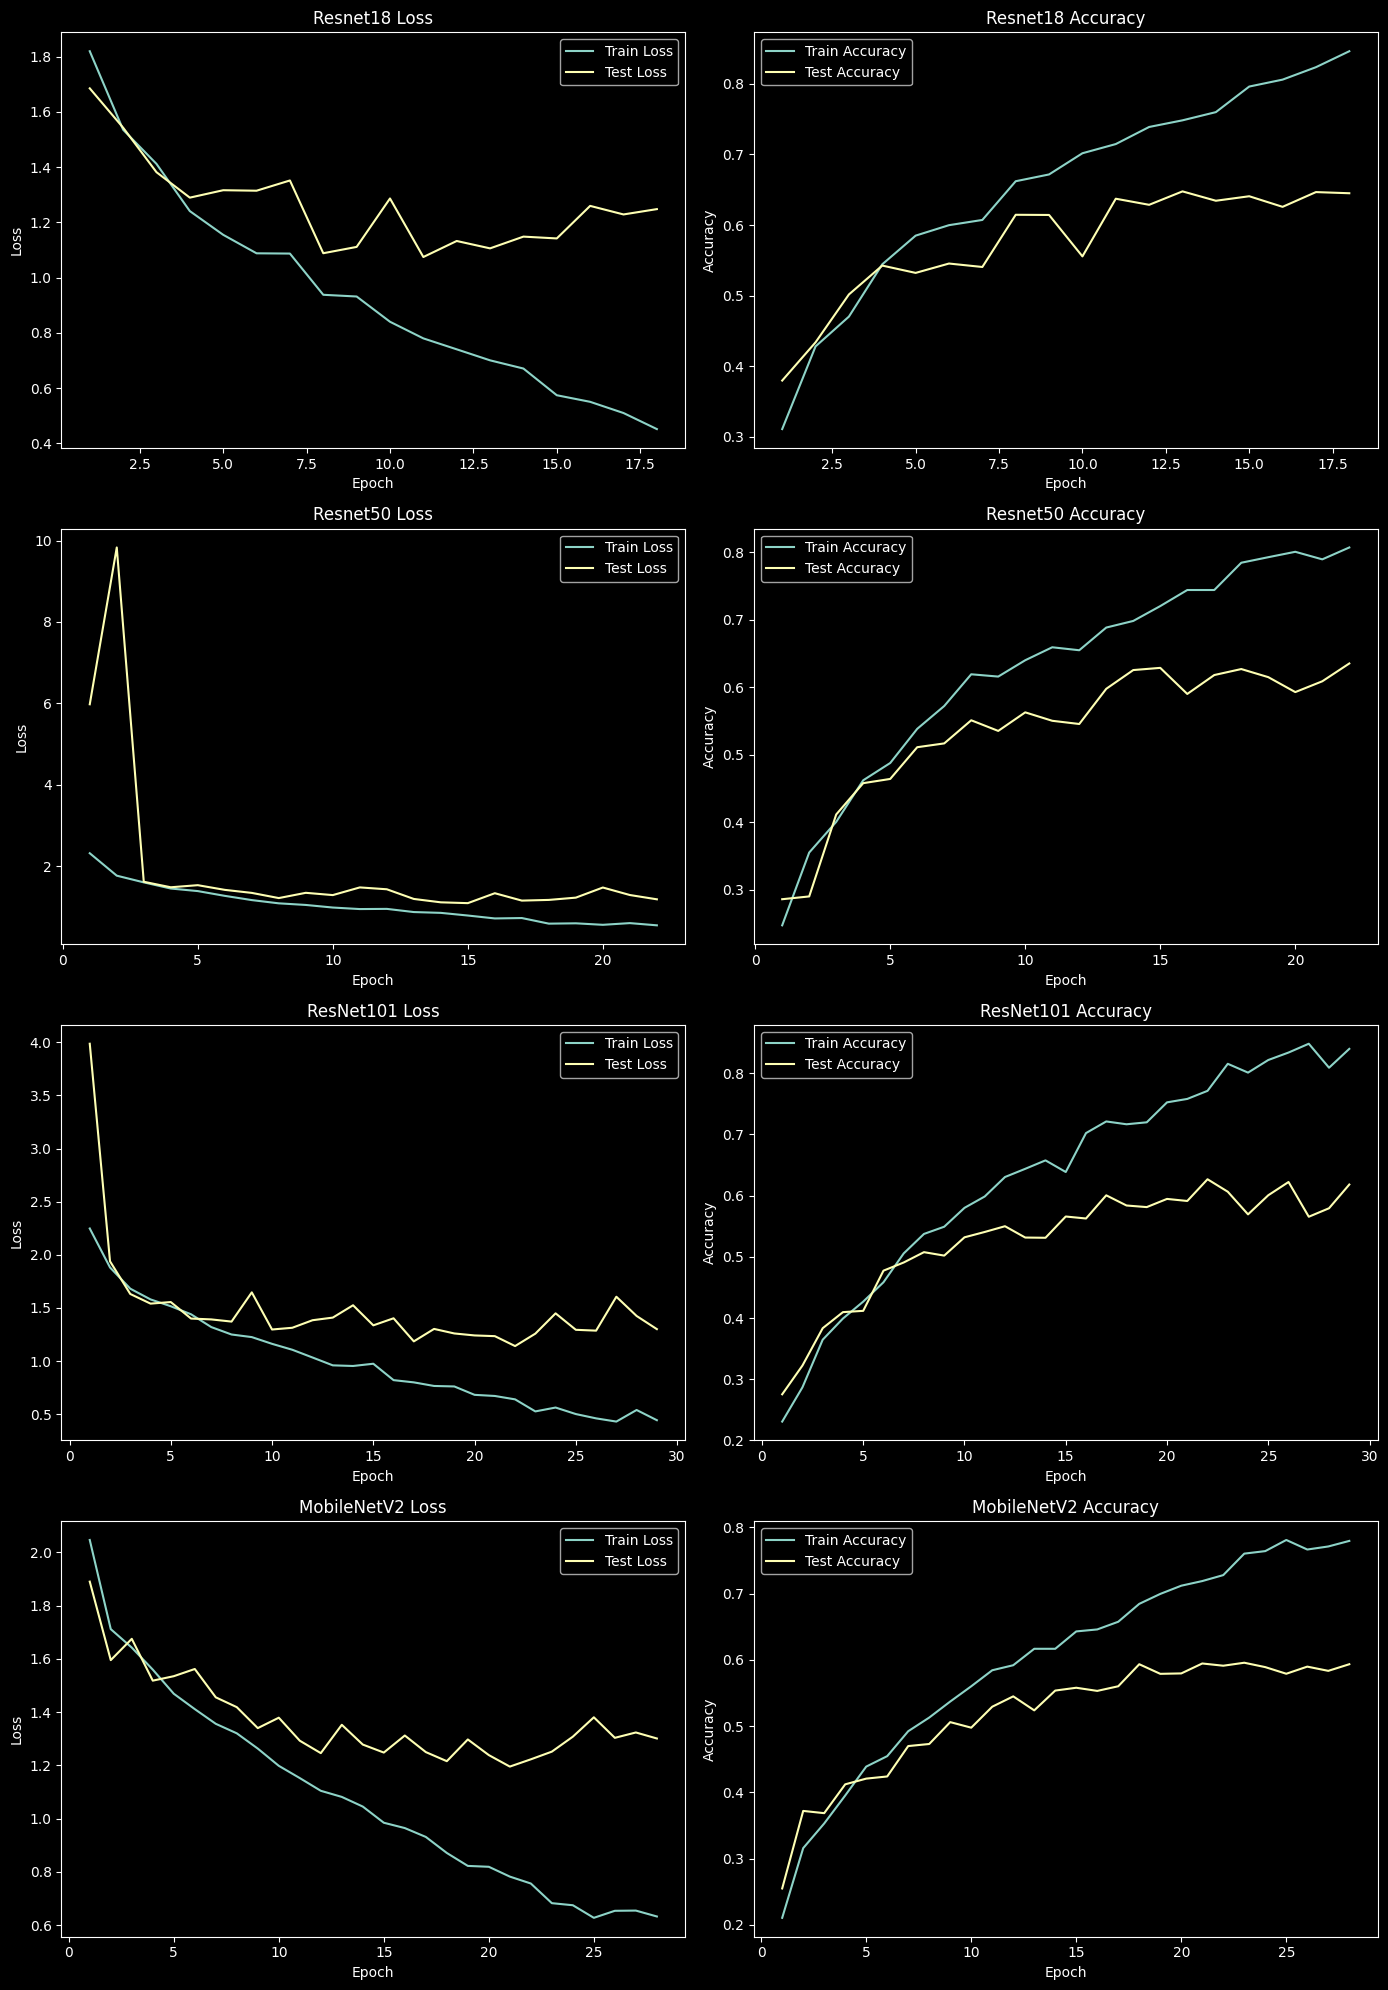

In [31]:
if RUN_SUPERVISED:
    plot_results(results)

# Bootstrap your own latent

Metoda [Bootstrap your own latent](https://arxiv.org/abs/2006.07733) jest opisana w rodziale 3.1 papieru a także w dodatku A. Składa się z dwóch etapów:


1.   uczenia samonadzorowanego (ang. *self-supervised*)
2.   douczania nadzorowanego (ang. *fine-tuning*)

## Uczenie samonadzorowane

Architektura do nauczania samonadzorowanego składa się z dwóch sieci: (1) *online* i (2) *target*. W uproszczeniu cała architektura działa tak:


1.   Dla obrazka $x$ wygeneruj dwie różne augmentacje $v$ i $v'$ za pomocą funkcji $t$ i $t'$.
2.   Widok $v$ przekazujemy do sieci *online*, a $v'$ do *target*.
3.   Następnie widoki przekształacamy za pomocą sieci do uczenia reprezentacji (np. resnet18 lub resnet50) do reprezentacji $y_\theta$ i $y'_\xi$.
4.   Potem dokonujemy projekcji tych reprezentacji w celu zmniejszenia wymiarowości (np. za pomocą sieci MLP).
5.   Na sieci online dokonujmey dodatkowo predykcji pseudo-etykiety (ang. *pseudolabel*)
6.   Wyliczamy fukncję kosztu: MSE z wyjścia predyktora sieci *online* oraz wyjścia projekcji sieci *target* "przepuszczonej" przez predyktor sieci *online* **bez propagacji wstecznej** (*vide Algorithm 1* z papieru).
7.   Dokonujemy wstecznej propagacji **tylko** po sieci *online*.
8.   Aktualizujemy wagi sieci *target* sumując w ważony sposób wagi obu sieci $\xi = \tau\xi + (1 - \tau)\theta$ ($\tau$ jest hiperprametrem) - jest to ruchoma średnia wykładnicza (ang. *moving exponential average*).

Po zakończeniu procesu uczenia samonadzorowanego zostawiamy do douczania sieć kodera *online* $f_\theta$. Cała sieć *target* oraz warstwy do projekcji i predykcji w sieci *online* są "do wyrzucenia".

### Augmentacja

Dodatek B publikacji opisuje augmentacje zastosowane w metodzie BYOL. Zwróć uwagę na tabelę 6 w publikacji. `torchvision.transforms.RandomApply` może być pomocne.

***Zaimeplementuj*** augmentację $\tau$ i $\tau'$.


In [ ]:
# Parametry transformacji
crop_size = 224
resize_size = 256
crop_area = (0.08, 1.0)
aspect_ratio = (3/4, 4/3)
brightness = 0.4
contrast = 0.4
saturation = 0.2
hue = 0.1
gaussian_kernel_size = 23
gaussian_sigma = (0.1, 2.0)
color_jitter_strength = 0.8

# Wspólne transformacje
random_crop = transforms.RandomResizedCrop(
    crop_size,
    scale=crop_area,
    ratio=aspect_ratio,
    interpolation=transforms.InterpolationMode.BICUBIC
)
random_flip = transforms.RandomHorizontalFlip(p=0.5)
color_jitter = transforms.ColorJitter(
    brightness=brightness,
    contrast=contrast,
    saturation=saturation,
    hue=hue
)

# Transformacja dla T
transform_T = transforms.Compose([
    # random_crop,
    random_flip,
    transforms.RandomApply([color_jitter], p=color_jitter_strength),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=gaussian_kernel_size, sigma=gaussian_sigma),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformacja dla T'
transform_T_prime = transforms.Compose([
    # random_crop,
    random_flip,
    transforms.RandomApply([color_jitter], p=color_jitter_strength),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=gaussian_kernel_size, sigma=gaussian_sigma)], p=0.1),
    transforms.RandomApply([transforms.Lambda(lambda x: torch.where(x < 0.5, x, 1 - x))], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Define a custom dataset class that returns tuples of images
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        return img, img

if RUN_UNSUPERVISED:
    # Load the STL10 dataset
    stl10_train_dataset = datasets.STL10(root='.', split='train', transform=transform_T, download=True)

    # Create instances of the custom dataset class
    custom_transform_t_dataset = CustomDataset(stl10_train_dataset)
    custom_transform_t_prime_dataset = CustomDataset(stl10_train_dataset)

    # Create DataLoader instances from the custom datasets
    transform_t_loader = torch.utils.data.DataLoader(custom_transform_t_dataset, batch_size=512, shuffle=True)
    transform_t_prime_loader = torch.utils.data.DataLoader(custom_transform_t_prime_dataset, batch_size=512, shuffle=True)


Files already downloaded and verified


### Implementacja uczenia samonadzorowanego

***Zaprogramuj*** proces uczenia samonadzorowanego na danych nieetykietowanych ze zbioru STL10.

Wskazówki do realizacji polecenia:

1. Proces uczenia może trwać bardzo długo dlatego zaleca się zastsowanie wczesnego zatrzymania lub uczenia przez tylko jedną epokę. Mimo wszystko powinno się dać osiągnąć poprawę w uczeniu nadzorowanym wykorzystując tylko zasoby z Google Colab.
2. Dobrze jest pominąć walidację na zbiorze treningowym i robić ją tylko na zbiorze walidacyjnym - zbiór treningowy jest ogromny i w związku z tym narzut czasowy na walidację też będzie duży.
3. Walidację modelu można przeprowadzić na zbiorze `train` lub całkowicie ją pominąć, jeżeli uczymy na stałej ilości epok.
4. Rozważ zastosowanie tylko jednej augmentacji - augmentacja $\tau'$ jest bardziej czasochłonna niż $\tau$.
5. Poniżej jest zaprezentowany zalążek kodu - jest on jedynie wskazówką i można na swój sposób zaimplementować tę metodę

In [ ]:
def mlp(encoder_output_dim, projection_size=128, hidden_dim=4096):
    return nn.Sequential(
        nn.Linear(encoder_output_dim, hidden_dim),
        nn.BatchNorm1d(hidden_dim),
        nn.ReLU(inplace=True),
        nn.Linear(hidden_dim, projection_size),
        nn.BatchNorm1d(projection_size)  
    )

In [ ]:
class BYOL(nn.Module):
    def __init__(self, model, encoder_out_shape=1000, projection_size=256, tau=0.999):
        super().__init__()
        self.encoder_online = model

        self.projector_online = mlp(encoder_out_shape, projection_size=projection_size)
        self.online_common = nn.Sequential(self.encoder_online, self.projector_online)
        self.predictor_online = nn.Linear(projection_size, projection_size)
        
        self.encoder_target = deepcopy(self.encoder_online)
        self.projector_target = deepcopy(self.projector_online)
        self.target = nn.Sequential(self.encoder_target, self.projector_target)

        self.tau = tau

    def forward(self, x1, x2):
        z1 = self.online_common(x1)
        z2 = self.online_common(x2)
        p1 = self.predictor_online(z1)
        p2 = self.predictor_online(z2)
        return z1, z2, p1, p2

    def update_target(self):
        for online_params, target_params in zip(self.online_common.parameters(), self.target.parameters()):
            target_params.data = self.tau * target_params.data + (1 - self.tau) * online_params.data

    def loss(self, z1, z2, p1, p2):
        z2 = z2.detach()
        p2 = p2.detach()
        return 0.5 * (nn.functional.mse_loss(p1, z2) + nn.functional.mse_loss(p2, z1))

In [ ]:
def train_byol(model, optimizer, loss_fn, train_dl, train_dl_prime, epochs=10, patience=5):
    metrics = {'train_loss': []}
    best_loss = float('inf')
    epochs_no_improve = 0
    early_stop = False

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0
        total = 0

        for (x1, _), (x2, _) in zip(train_dl, train_dl_prime):
            x1, x2 = x1.to(device), x2.to(device)
            optimizer.zero_grad()
            z1, z2, p1, p2 = model(x1, x2)
            loss = model.loss(z1, z2, p1, p2)
            loss.backward()
            optimizer.step()
            model.update_target()

            epoch_train_loss += loss.item() * x1.size(0)
            total += x1.size(0)

        train_loss = epoch_train_loss / total
        metrics['train_loss'].append(train_loss)
        print(f"Epoch {epoch}: train loss = {train_loss:.3f}")

        if train_loss < best_loss:
            best_loss = train_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {patience} epochs without improvement")
                early_stop = True
                break

        if early_stop:
            print("Training stopped early")
            break

    return metrics, model

In [ ]:
if RUN_UNSUPERVISED:
    model = BYOL(models.resnet18(weights=None)).to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    byol_results = {}
    byol_results['BYOL'], model = train_byol(
        model,
        optimizer,
        model.loss,
        transform_t_loader,
        transform_t_prime_loader,
        epochs=100,
        patience=7
    )

Epoch 0: train loss = 1.142
Epoch 1: train loss = 0.998
Epoch 2: train loss = 0.965
Epoch 3: train loss = 0.943
Epoch 4: train loss = 0.925
Epoch 5: train loss = 0.907
Epoch 6: train loss = 0.892
Epoch 7: train loss = 0.870
Epoch 8: train loss = 0.853
Epoch 9: train loss = 0.839
Epoch 10: train loss = 0.822
Epoch 11: train loss = 0.807
Epoch 12: train loss = 0.792
Epoch 13: train loss = 0.778
Epoch 14: train loss = 0.764
Epoch 15: train loss = 0.749
Epoch 16: train loss = 0.737
Epoch 17: train loss = 0.722
Epoch 18: train loss = 0.710
Epoch 19: train loss = 0.697
Epoch 20: train loss = 0.685
Epoch 21: train loss = 0.673
Epoch 22: train loss = 0.661
Epoch 23: train loss = 0.649
Epoch 24: train loss = 0.638
Epoch 25: train loss = 0.627
Epoch 26: train loss = 0.617
Epoch 27: train loss = 0.606
Epoch 28: train loss = 0.596
Epoch 29: train loss = 0.587
Epoch 30: train loss = 0.578
Epoch 31: train loss = 0.567
Epoch 32: train loss = 0.556
Epoch 33: train loss = 0.548
Epoch 34: train loss = 0

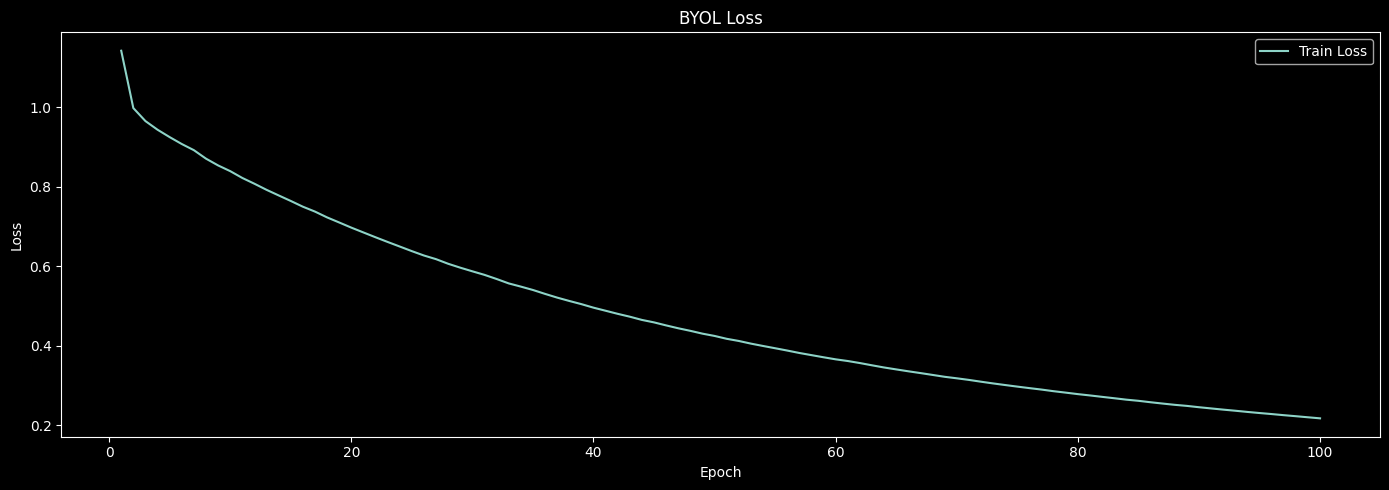

In [ ]:
if RUN_UNSUPERVISED:
    plot_results(byol_results, ncols=1)

## Douczanie nadzorowane

***Zaimplementuj*** proces douczania kodera z poprzedniego polecenia na danych etykietowanych ze zbioru treningowego. Porównaj jakość tego modelu z modelem nauczonym tylko na danych etykietownaych. Postaraj się wyjaśnić różnice.

In [ ]:
def fine_tune_supervised(model, train_loader, test_loader, epochs=10, lr=0.001, patience=5):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    metrics = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }
    best_val_loss = float('inf')
    epochs_no_improve = 0
    early_stop = False

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        train_loss /= train_total
        train_acc = train_correct / train_total

        # Walidacja
        model.eval()
        test_loss = 0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)

                test_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                test_total += labels.size(0)
                test_correct += predicted.eq(labels).sum().item()

        test_loss /= test_total
        test_acc = test_correct / test_total

        metrics['train_loss'].append(train_loss)
        metrics['train_acc'].append(train_acc)
        metrics['test_loss'].append(test_loss)
        metrics['test_acc'].append(test_acc)

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

        # Early stopping logic
        if test_loss < best_val_loss:
            best_val_loss = test_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {patience} epochs without improvement")
                early_stop = True
                break

    return metrics

In [ ]:
state_dict = model.encoder_online.state_dict()
encoder = model.encoder_online
encoder.load_state_dict(state_dict)
num_ftrs = encoder.fc.in_features
encoder.fc = nn.Linear(num_ftrs, 10)

encoder = encoder.to(device)

fine_tune_supervised_metrics = {}
fine_tune_supervised_metrics['Fine tuned supervised v1'] = fine_tune_supervised(encoder, train_loader, test_loader, epochs=100, patience=7)

Epoch 1: Train Loss: 1.7980, Train Acc: 0.3176, Test Loss: 1.9133, Test Acc: 0.3289
Epoch 2: Train Loss: 1.5460, Train Acc: 0.3986, Test Loss: 1.4612, Test Acc: 0.4422
Epoch 3: Train Loss: 1.4450, Train Acc: 0.4580, Test Loss: 1.4707, Test Acc: 0.4502
Epoch 4: Train Loss: 1.3077, Train Acc: 0.5108, Test Loss: 1.2971, Test Acc: 0.5108
Epoch 5: Train Loss: 1.2204, Train Acc: 0.5460, Test Loss: 1.3033, Test Acc: 0.5290
Epoch 6: Train Loss: 1.1130, Train Acc: 0.5976, Test Loss: 1.1851, Test Acc: 0.5647
Epoch 7: Train Loss: 1.0270, Train Acc: 0.6142, Test Loss: 1.2617, Test Acc: 0.5503
Epoch 8: Train Loss: 0.9838, Train Acc: 0.6426, Test Loss: 1.2371, Test Acc: 0.5741
Epoch 9: Train Loss: 0.9320, Train Acc: 0.6616, Test Loss: 1.1178, Test Acc: 0.5975
Epoch 10: Train Loss: 0.8283, Train Acc: 0.6956, Test Loss: 1.1096, Test Acc: 0.6198
Epoch 11: Train Loss: 0.7562, Train Acc: 0.7314, Test Loss: 1.1030, Test Acc: 0.6278
Epoch 12: Train Loss: 0.7202, Train Acc: 0.7374, Test Loss: 1.1673, Test A

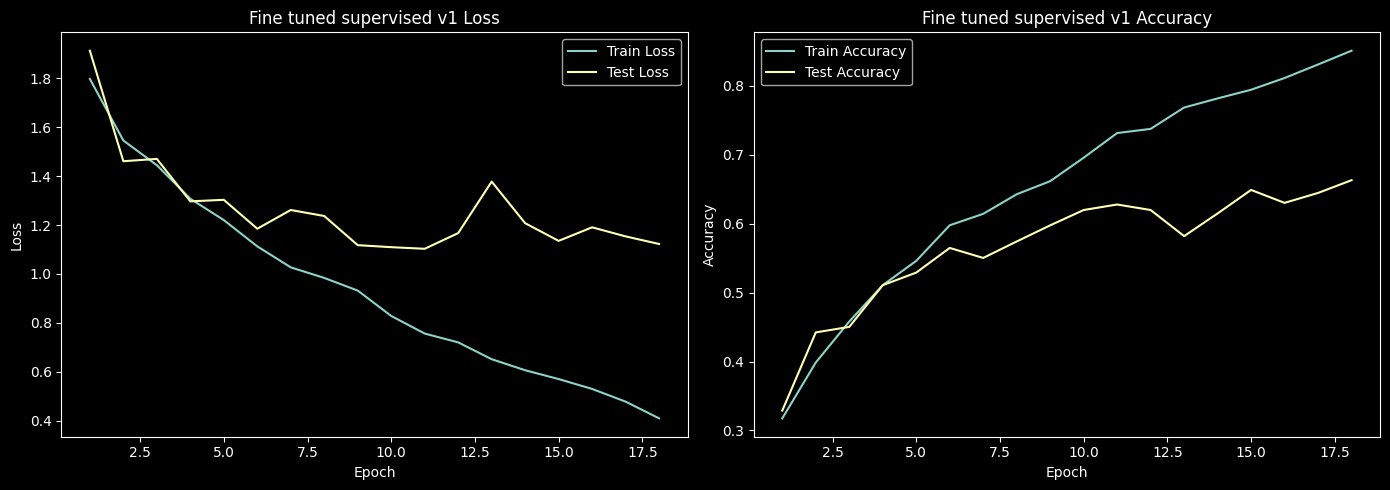

In [ ]:
plot_results(fine_tune_supervised_metrics)